In [1]:
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
%matplotlib inline

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
current_dir = os.getcwd()
print(current_dir)

G:\Datasets\COVID-XRAY\main_dataset


In [4]:
image_dim = [224,224]

epochs = 100
batch_size = 32

covid_path = os.path.join(current_dir + '/chest/Chest_COVID')
noncovid_path = os.path.join(current_dir + '/chest/Chest_NonCOVID')

covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')


In [5]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
    image = cv2.imread(covid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    covid_images.append(image)
    covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
    image = cv2.imread(noncovid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    noncovid_images.append(image)
    noncovid_labels.append('Chest_NonCOVID')

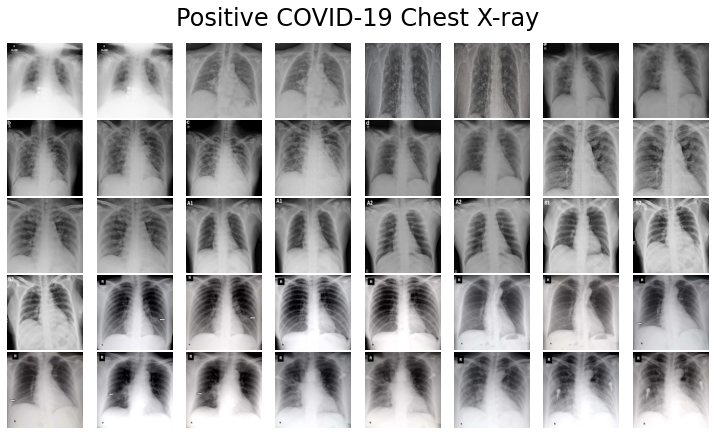

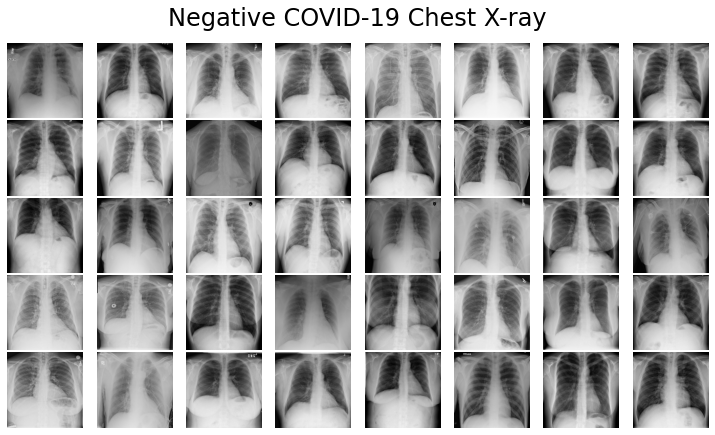

In [6]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

In [7]:
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

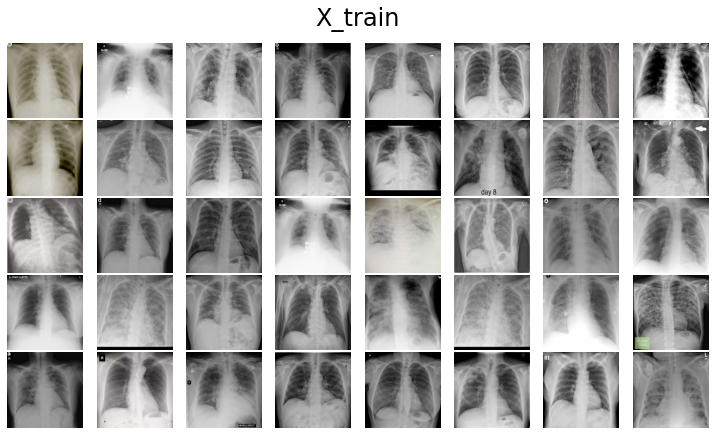

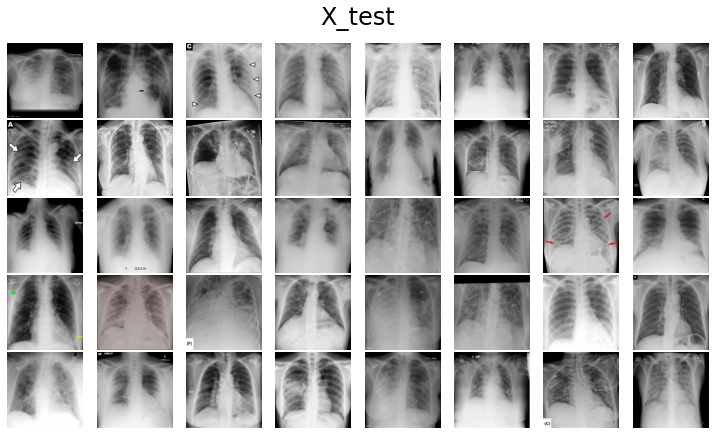

In [9]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

In [14]:
import tensorflow
mobile = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (224,224,3))

outputs = mobile.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.4)(outputs)
outputs = Dense(512, activation = 'relu')(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=mobile.input, outputs=outputs)

for layer in mobile.layers:
    layer.trainable = False
      

model.compile(
        loss='categorical_crossentropy', 
        optimizer=tensorflow.keras.optimizers.Adadelta(learning_rate = 0.003), 
        metrics=['accuracy']
)

train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range = 0.1
)

In [11]:
#name_model = input("model name  : ")

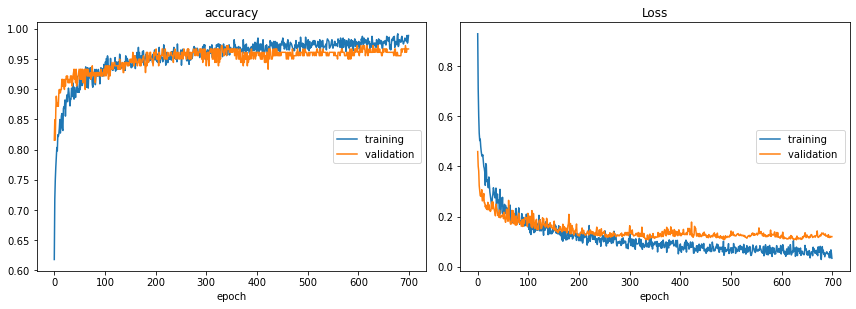

accuracy
	training         	 (min:    0.618, max:    0.992, cur:    0.989)
	validation       	 (min:    0.816, max:    0.972, cur:    0.966)
Loss
	training         	 (min:    0.029, max:    0.928, cur:    0.034)
	validation       	 (min:    0.108, max:    0.459, cur:    0.120)
23/22 [===============================] - 7s 307ms/step - loss: 0.0337 - accuracy: 0.9888 - val_loss: 0.1199 - val_accuracy: 0.9665
Wall time: 1h 34min 18s


In [15]:
%%time
import tensorflow
from livelossplot import PlotLossesKerasTF

#chkpt = tensorflow.keras.callbacks.ModelCheckpoint(name_model, monitor = 'val_accuracy', verbose = 1, save_best_only = True)
#tensorboard = tensorflow.keras.callbacks.TensorBoard(log_dir = 'logs/mob1')

history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=700,
                   callbacks = [PlotLossesKerasTF()])

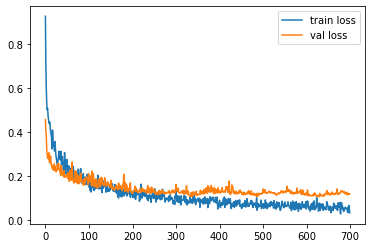

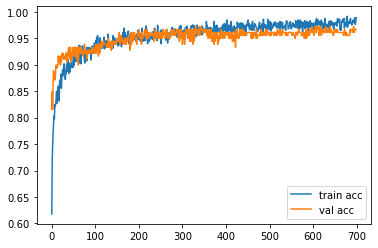

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()

In [17]:
model.save('mobilenet003.h5')
model.save_weights('mobilenet003.hdf5')


In [18]:
model.load_weights('mobilenet003.h5')

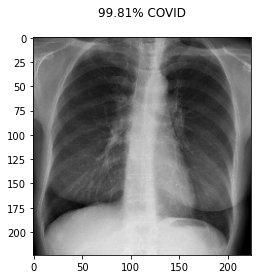

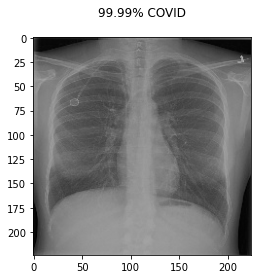

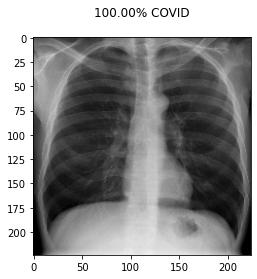

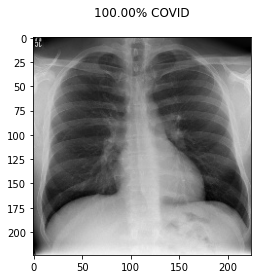

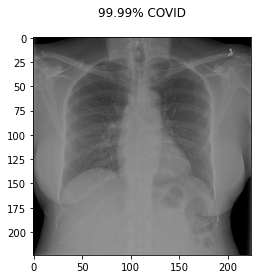

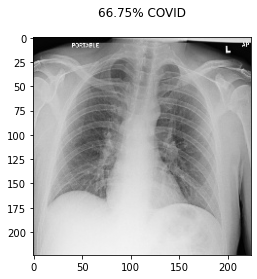

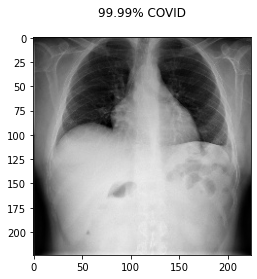

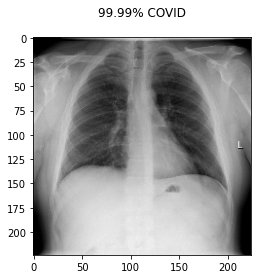

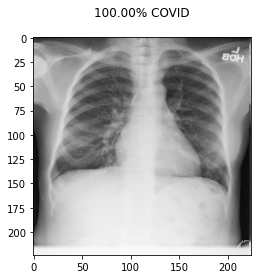

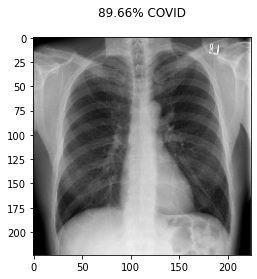

In [19]:
y_pred = model.predict(X_test, batch_size=batch_size)
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID' + '\n' )
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
    plt.imshow(X_test[index])
    plt.show()

In [20]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

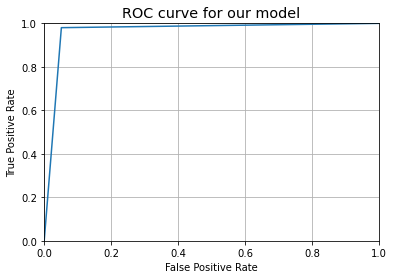

In [21]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


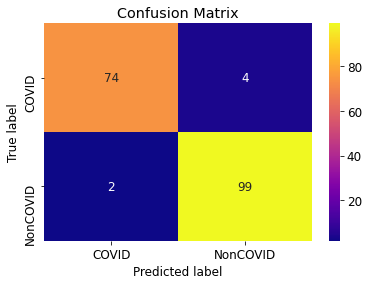

Confusion Matrix with Normalized Values


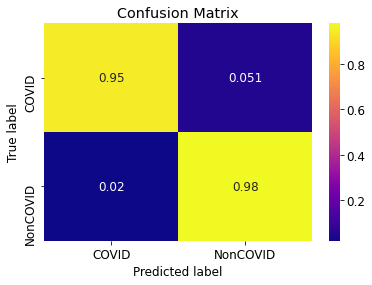

In [22]:
def plot_confusion_matrix(normalize):
    classes = ['COVID','NonCOVID']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
    sns.heatmap(cn,cmap='plasma',annot=True)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        78
           1       0.96      0.98      0.97       101

    accuracy                           0.97       179
   macro avg       0.97      0.96      0.97       179
weighted avg       0.97      0.97      0.97       179



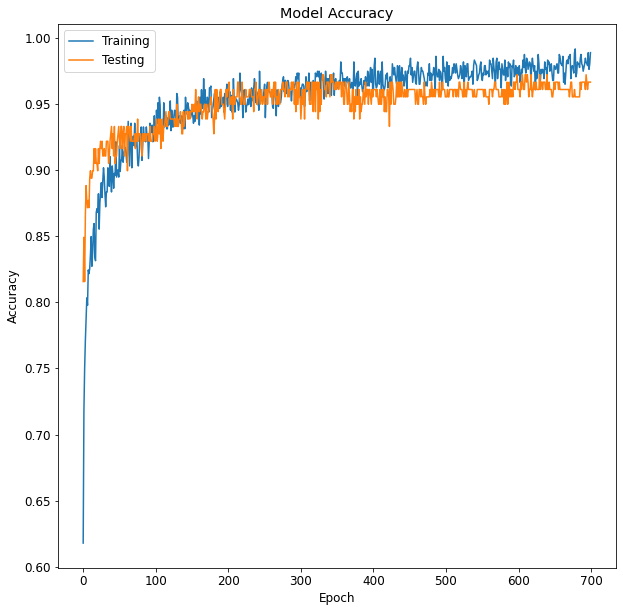

In [24]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('mobilenet003_acc.png')
plt.show()


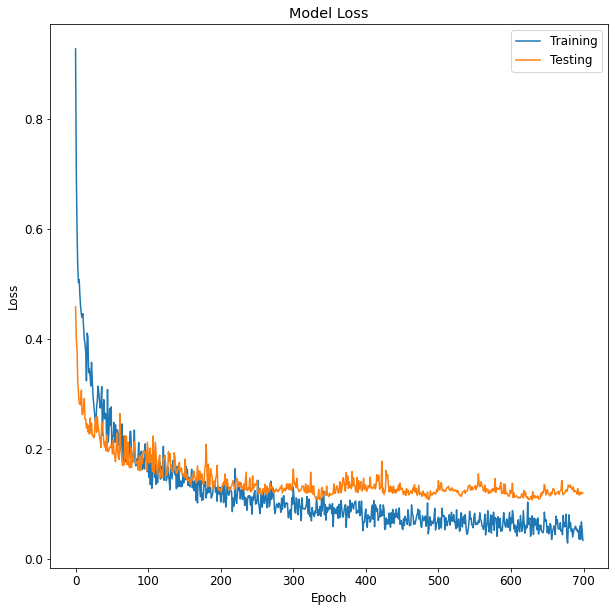

In [25]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('mobilenet003.png')
plt.show()

In [86]:
#!pip install gradio
import gradio as gr
labels = ['COVID +ve', 'Normal']

def classify_image(inp):
    inp = inp.reshape((-1, 244, 244, 3))
    inp = tensorflow.keras.applications.mobilenet_v2.preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(2)}



image = gr.inputs.Image(shape=(244, 244, 3))
label = gr.outputs.Label(num_top_classes=2)

gr.Interface(fn=classify_image, inputs=image, outputs=label, capture_session=True).launch()

Running locally at: http://127.0.0.1:7867/


(<gradio.networking.serve_files_in_background.<locals>.HTTPServer at 0x26c2b5dea08>,
 'http://127.0.0.1:7867/',
 None)

In [ ]:
import tensorflow as tf
savedModel = "mobilenet_003_V1"
tf.saved_model.save(model, savedModel)
converter = tf.lite.TFLiteConverter.from_saved_model(savedModel)
tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)
    
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()